### Background
How to Deploy more than one model on a same endpoint

 #### Prerequisites 
 Choose Kernel for this notebook.<br>
 Under `Kernel` tab at the top of this notebook &#8594; `Choose kernel`, select `conda_python3` 

In [78]:
cd ..

/home/ec2-user/SageMaker/temp


In [1]:
%%capture
!pip install tensorflow==2.3.0

#### Imports 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sagemaker.tensorflow.serving import TensorFlowModel
from sagemaker.multidatamodel import MultiDataModel
from tensorflow.keras.datasets import cifar10
from sagemaker.tensorflow import TensorFlow
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
from tensorflow.keras import utils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
import numpy as np
import sagemaker
import logging
import boto3
import time
import os

#### Setup Logger

In [3]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [4]:
logger.info(f'[Using TensorFlow version: {tf.__version__}]')
logger.info(f'[Using SageMaker version: {sagemaker.__version__}]')

[Using TensorFlow version: 2.3.0]
[Using SageMaker version: 2.45.0]


#### Seed for Reproducability

In [5]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Create Roles, Sessions and Data Locations

In [6]:
role = get_execution_role()
session = boto3.Session()
sagemaker_session = sagemaker.Session()

s3 = session.resource('s3')
TF_FRAMEWORK_VERSION = '2.3.0'
BUCKET = sagemaker.Session().default_bucket()
PREFIX = 'cv-models'

### Create a Multi-Model Endpoint

#### a) Copy Trained Models to a common S3 Prefix

In [67]:
# output_1 = f's3://{BUCKET}/{PREFIX}/mme/mnist.tar.gz'

In [ ]:
# !aws s3 cp {tf_model_1} {output_1}

#### b) Essentials

In [8]:
# Getting current time
current_time = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
current_time

# Docker container and saved model prefix
IMAGE_URI = '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu-py37-ubuntu18.04'
model_data_prefix = f's3://{BUCKET}/{PREFIX}/mme/'

#### c) Create a MultiDataModel using Model 1 

In [9]:
# First Model path
output_1 = f's3://{BUCKET}/{PREFIX}/mme/model.tar.gz'
model_1 = TensorFlowModel(model_data=output_1, 
                          role=role, 
                          image_uri=IMAGE_URI)

In [10]:
# Creating multi model endpoint
mme = MultiDataModel(name=f'mme-tensorflow-{current_time}',
                     model_data_prefix=model_data_prefix,
                     model=model_1,
                     sagemaker_session=sagemaker_session)

#### d) Deploy Multi-Model Endpoint

In [11]:
# Deploying models
predictor = mme.deploy(initial_instance_count=1,
                       instance_type='ml.m5.xlarge',
                       endpoint_name=f'mme-tensorflow-{current_time}')


-------------!

In [68]:
# List all models in a directory
list(mme.list_models())

['',
 'dcb.tar.gz',
 'detect_wm_old.tar.gz',
 'mnist.tar.gz',
 'model.tar.gz',
 'model_old.tar.gz']

### Test Multi-Model Endpoint for Real Time Inference 

In [13]:
# importing libraies for real time inference
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from IPython.display import Image
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import numpy as np

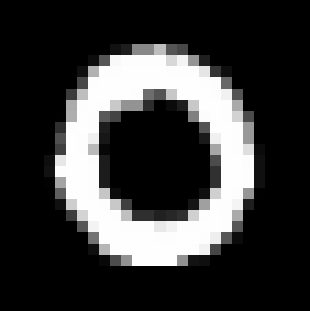

In [72]:
# this is for mnist dataset
img_path = './data/mnist_0.png'
MNIST10_labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']


# Convert image to model
img = load_img(img_path,color_mode = 'grayscale' ,  target_size=(28, 28))
data = img_to_array(img)
data = data.astype('float32')
data = data / 255.0
data = data.reshape(1, 784)
#Display Image
Image(img_path)

In [16]:
#this is for custom model 
# img = load_img('./data/cifar_10/raw_images/airplane.png', target_size=(380, 380))
# data = img_to_array(img)
# data = data.astype('float32')
# data = data / 255.0
# data = data.reshape(1, 380, 380, 3)

In [73]:
data.shape

(1, 784)

In [74]:
payload = {'instances': data}
y_pred = predictor.predict(data=payload, initial_args={'TargetModel': 'mnist.tar.gz'})

In [76]:
y_pred

{'predictions': [[10.554738,
   -10.4565191,
   3.4996202,
   -2.656286,
   -8.83644485,
   -1.92569876,
   -4.13440418,
   -2.65947747,
   -4.99284172,
   0.124290891]]}

In [75]:
predicted_label = MNIST10_labels[np.argmax(y_pred)]
print(f'Total Number of labels {len(list(y_pred.values())[0][0])}')

Total Number of labels 10
